# 0.0 Imports

In [389]:
import pandas as pd
import regex as re
import numpy as np

from sklearn  import model_selection as ms
import seaborn as sns
import matplotlib.pyplot as plt

# 0.1 Helper functions

# 0.2 Loading data

In [2]:
df_raw_1 = pd.read_csv('../data/data-1703806461.csv')
df_raw_2 = pd.read_csv('../data/data-1703806894.csv')
df_raw_3 = pd.read_csv('../data/data-1703805541.csv')
df_raw_4 = pd.read_csv('../data/data-1703779777.csv')
df_raw_5 = pd.read_csv('../data/data-1703969930.csv')

df_raw = pd.concat([df_raw_1, df_raw_2, df_raw_3, df_raw_4, df_raw_5])
df_raw = df_raw.drop_duplicates(subset=['id'])

# 1.0 Data description

In [295]:
df1 = df_raw.copy()

## 1.1 Data dimension

In [255]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 22341
Number of cols: 12


## 1.2 Data types

In [256]:
df1.dtypes

Unnamed: 0                    int64
id                            int64
usableAreas                  object
createdAt                    object
displayAddressGeolocation    object
parkingSpaces                object
suites                       object
bathrooms                    object
bedrooms                     object
pricingInfos                 object
amenities                    object
unitFloor                     int64
dtype: object

## 1.3 Check NA

In [257]:
df1.isna().sum()

Unnamed: 0                      0
id                              0
usableAreas                     0
createdAt                       0
displayAddressGeolocation    1218
parkingSpaces                   0
suites                          0
bathrooms                       0
bedrooms                        0
pricingInfos                    0
amenities                       0
unitFloor                       0
dtype: int64

## 1.4 Drop NA

In [296]:
df1 = df1.dropna()

In [297]:
df1 = df1.drop(columns=['Unnamed: 0'], axis=1)

## 1.5 Change types

In [298]:
# Removing the [''] from values, extracting only the numbers
df1['usableAreas'] = df1['usableAreas'].str.extract(r"(\d+)")
df1['parkingSpaces'] = df1['parkingSpaces'].str.extract(r"(\d+)")
df1['suites'] = df1['suites'].str.extract(r"(\d+)")
df1['bathrooms'] = df1['bathrooms'].str.extract(r"(\d+)").astype('int64')
df1['bedrooms'] = df1['bedrooms'].str.extract(r"(\d+)").astype('int64')

# Converting to int64
df1['usableAreas'] = df1['usableAreas'].astype('int64')
df1['parkingSpaces'] = df1['parkingSpaces'].fillna(0).astype('int64')
df1['suites'] = df1['suites'].fillna(0).astype('int64')

In [301]:
# Converting to date type
df1['createdAt_dt'] = pd.to_datetime(df1['createdAt'], format='ISO8601')

In [302]:
df1.dtypes

id                                         int64
usableAreas                                int64
createdAt                                 object
displayAddressGeolocation                 object
parkingSpaces                              int64
suites                                     int64
bathrooms                                  int64
bedrooms                                   int64
pricingInfos                              object
amenities                                 object
unitFloor                                  int64
createdAt_dt                 datetime64[ns, UTC]
dtype: object

## 1.6 Descriptive statistical

In [306]:
num_attributes = df1[['id', 'usableAreas', 'parkingSpaces', 'suites', 'bathrooms', 'bedrooms', 'unitFloor']]
#cat_attributes = df1[[]]

In [308]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [309]:
# Numerical attributes
df_aux = num_attributes.describe().T[['min', 'max', 'mean', 'std']]
range_ = df_aux['min'] - df_aux['max']
kurt = num_attributes.kurt(axis=0)
skew = num_attributes.skew(axis=0)

df_aux['range'] = range_
df_aux['kurt'] = kurt
df_aux['skew'] = skew

df_aux

,min,max,mean,std,range,kurt,skew
id,39560479.000,2679904494.000,2627133188.587,213302692.640,-2640344015.000,118.208,-10.558
usableAreas,10.000,5000.000,97.786,99.832,-4990.000,806.516,19.907
parkingSpaces,0.000,190.000,1.519,1.867,-190.000,5337.881,57.873
suites,0.000,6.000,1.010,1.054,-6.000,0.638,1.094
bathrooms,0.000,12.000,2.242,1.319,-12.000,1.153,1.167
bedrooms,1.000,12.000,2.385,0.836,-11.000,1.464,0.361
unitFloor,0.000,191.000,3.256,7.482,-191.000,62.665,5.673


# 2.0 Feature engineering

In [357]:
df2 = df1.copy()

## 2.1 Feature engineering

In [358]:
# Dealing with 'displayAddressGeolocation'
df2[['locationLon', 'locationLat']] = df2['displayAddressGeolocation'].str.split(',', expand=True)

df2['locationLat'] = df2['locationLat'].str.replace("'lat': ", "").str.replace('}', '').astype(float)

df2['locationLon'] = df2['locationLon'].str.replace("{'lon': ", "").str.replace('{', '').astype(float)

In [359]:
# Dealing with 'pricingInfos'
df2['yearlyIptu'] = df2['pricingInfos'].str.findall(r"(yearlyIptu)': '(\d+)").astype(str).str.extract(r"(\d+)")

df2['price'] = df2['pricingInfos'].str.findall(r"(price)': '(\d+)").astype(str).str.findall(r"(\d+)").apply(lambda x: x[1] if len(x)>1 else x[0])

df2['monthlyCondoFee'] = df2['pricingInfos'].str.findall(r"(monthlyCondoFee)': '(\d+)").astype(str).str.extract(r"(\d+)")

In [364]:
# Converting to int type

df2['price'] = df2['price'].astype('int64')

In [360]:
# Dealing with 'amenities'

## Converting to a list
df2['amenitiesList'] = df2['amenities'].str.findall(r"[a-zA-Z]+")

## Count of amenities
df2['amenitiesCount'] = df2['amenitiesList'].apply(lambda x: len(x))

## Has elevator
df2['amenitiesElevator'] = df2['amenitiesList'].apply(lambda x: 1 if 'ELEVATOR' in x else 0)

## Has pool
df2['amenitiesPool'] = df2['amenitiesList'].apply(lambda x: 1 if 'POOL' in x else 0)

## Has gym
df2['amenitiesGym'] = df2['amenitiesList'].apply(lambda x: 1 if 'GYM' in x else 0)

## Has barbecue
df2['amenitiesBarbecue'] = df2['amenitiesList'].apply(lambda x: 1 if 'BARBECUE' in x else 0)

In [361]:
# Dealing with 'createdAt_dt'

## year
df2['createdAt_year'] = df2['createdAt_dt'].dt.year

## month
df2['createdAt_month'] = df2['createdAt_dt'].dt.month

## day
df2['createdAt_day'] = df2['createdAt_dt'].dt.day

In [365]:
# Creating unitary value - this feature will be the response of our project

df2['unitaryValue'] = df2['price'] / df2['usableAreas']

In [366]:
# Drop equivalents columns
columns = ['createdAt', 'displayAddressGeolocation', 'pricingInfos', 'amenities', 'price']
df2 = df2.drop(columns=columns, axis=1).copy()

## 2.2 Splitting dataset

In [375]:
X = df2.drop('unitaryValue', axis=1).copy()
y = df2['unitaryValue'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 0.20, random_state = 42)

df2 = pd.concat([X_train, y_train], axis=1)

df_test = pd.concat([X_test, y_test], axis=1)

# 3.0 Feature filtering

In [376]:
df3 = df2.copy()

## 3.1 Row filtering

## 3.2 Column filtering

In [384]:
cols_drop = ['amenitiesList']
df3 = df3.drop(cols_drop, axis=1)
df3.columns

Index(['id', 'usableAreas', 'parkingSpaces', 'suites', 'bathrooms', 'bedrooms',
       'unitFloor', 'createdAt_dt', 'locationLon', 'locationLat', 'yearlyIptu',
       'monthlyCondoFee', 'amenitiesCount', 'amenitiesElevator',
       'amenitiesPool', 'amenitiesGym', 'amenitiesBarbecue', 'createdAt_year',
       'createdAt_month', 'createdAt_day', 'unitaryValue'],
      dtype='object')

# 4.0 Exploratory data analysis

In [385]:
df4 = df3.copy()

Let's update the descriptive statiscal with the new features

In [386]:
num_attributes = df4.select_dtypes(include=['int32', 'int64', 'float64'])

In [387]:
# Numerical attributes
df_aux = num_attributes.describe().T[['min', 'max', 'mean', 'std']]
range_ = df_aux['min'] - df_aux['max']
kurt = num_attributes.kurt(axis=0)
skew = num_attributes.skew(axis=0)

df_aux['range'] = range_
df_aux['kurt'] = kurt
df_aux['skew'] = skew

df_aux

,min,max,mean,std,range,kurt,skew
id,39560479.000,2679904494.000,2627445700.375,210832084.656,-2640344015.000,120.412,-10.646
usableAreas,10.000,5000.000,97.576,101.376,-4990.000,881.043,21.226
parkingSpaces,0.000,98.000,1.512,1.405,-98.000,1620.505,26.551
suites,0.000,6.000,1.010,1.057,-6.000,0.622,1.094
bathrooms,0.000,12.000,2.242,1.319,-12.000,1.154,1.168
bedrooms,1.000,12.000,2.384,0.835,-11.000,1.890,0.400
unitFloor,0.000,191.000,3.235,7.476,-191.000,66.285,5.775
locationLon,-49.057,-38.472,-46.647,0.099,-10.585,2841.788,34.607
locationLat,-23.948,-6.177,-23.571,0.168,-17.771,7799.406,81.944
amenitiesCount,0.000,157.000,16.838,18.309,-157.000,6.060,2.206


## 4.1 Univariate analysis

### 4.1.1 Target variable

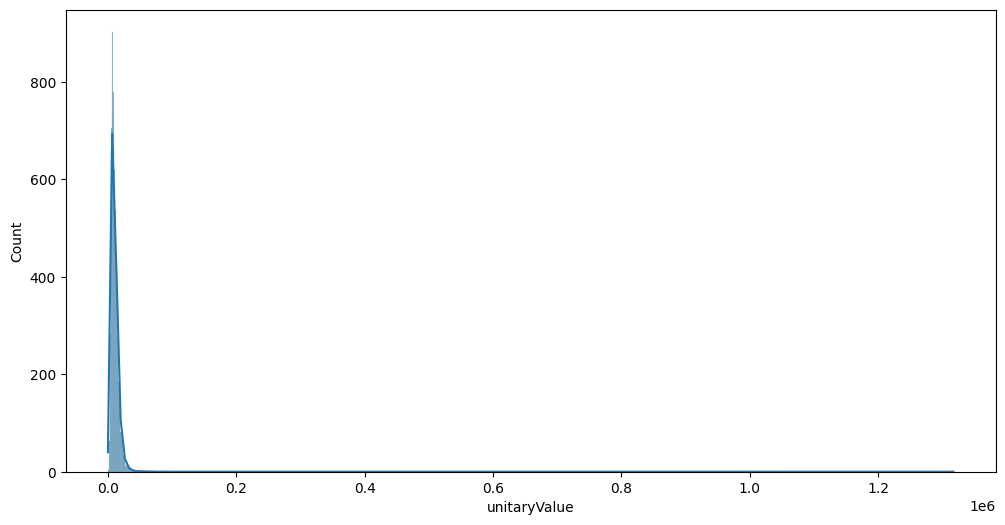

In [391]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(df4['unitaryValue'], kde = True, ax = ax)
plt.show()

### 4.1.2 Numerical variable

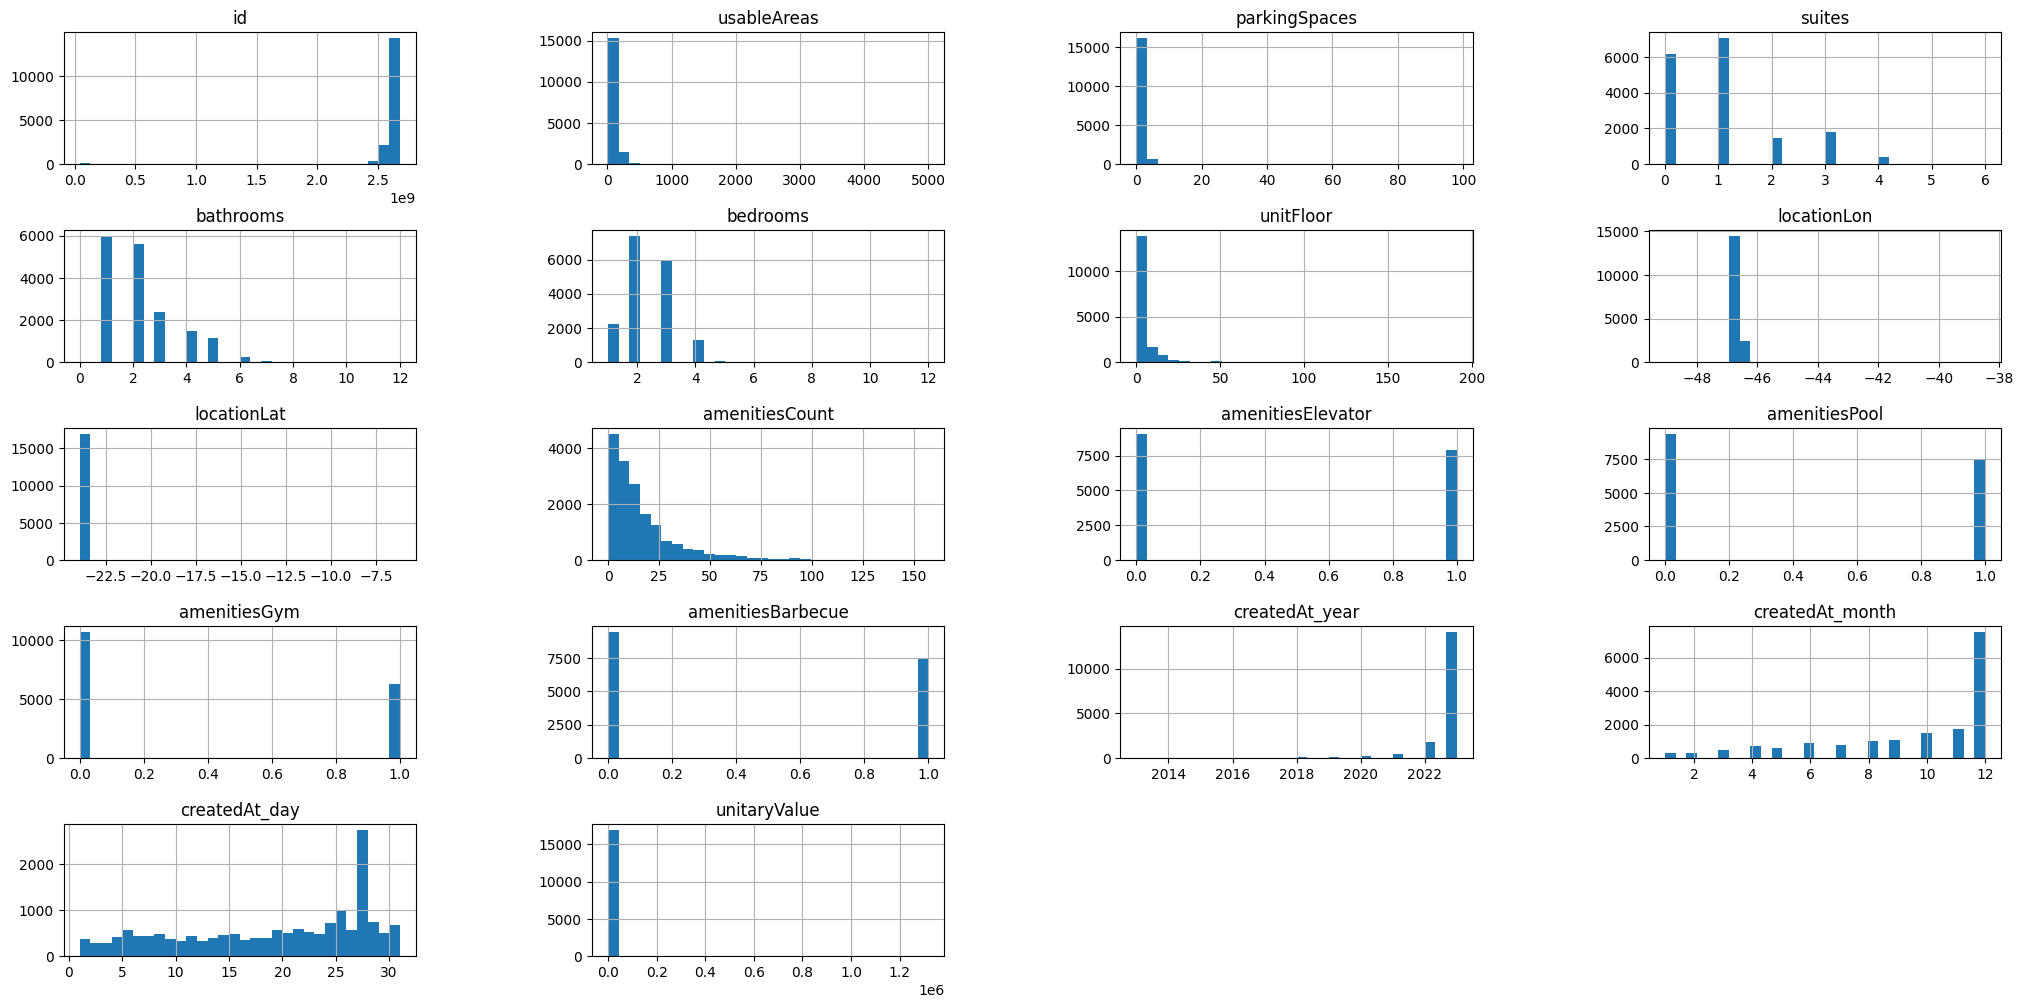

In [392]:
ax = num_attributes.hist(bins=30, figsize = (25,12), layout=(5,4));
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## 4.2 Bivariate analysis

Some hipothesis:
- Large areas -> higher unitary
- More parking spaces -> higher unitary value
- More suites -> higher unitary value
- More bathrooms - > higher unitary value
- More bedrooms -> higher unitary value
- High unit floor -> higher unitary value
- More amenities -> higher unitary value
- Has elevator, pool, gym or barbecue -> higher unitary value



#### Large areas: *true*

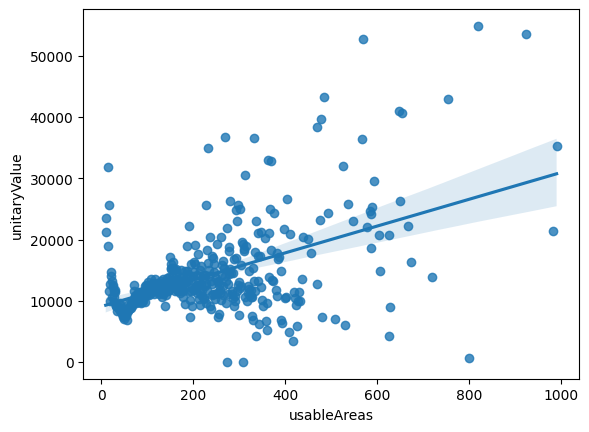

In [398]:
aux0 = df4[(df4['usableAreas'] < 1000) & (df4['unitaryValue'] < 60000)]

aux1 = aux0[['usableAreas', 'unitaryValue']].groupby('usableAreas').mean().reset_index()

sns.regplot(x='usableAreas', y='unitaryValue', data=aux1);

#### Parking spaces: *true*

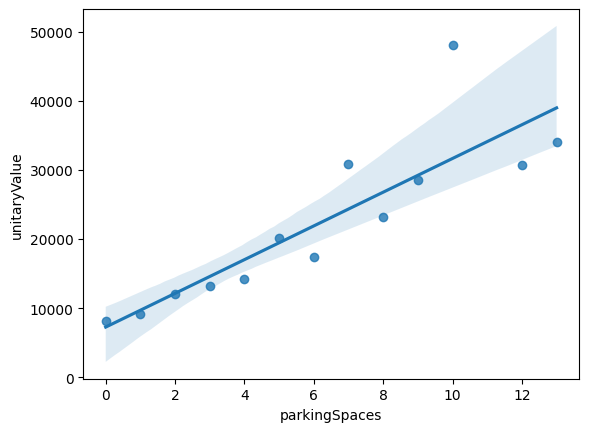

In [401]:
aux0 = df4[(df4['parkingSpaces'] < 20) & (df4['unitaryValue'] < 60000)]

aux1 = aux0[['parkingSpaces', 'unitaryValue']].groupby('parkingSpaces').mean().reset_index()

sns.regplot(x='parkingSpaces', y='unitaryValue', data=aux1);

#### Suites: *true*

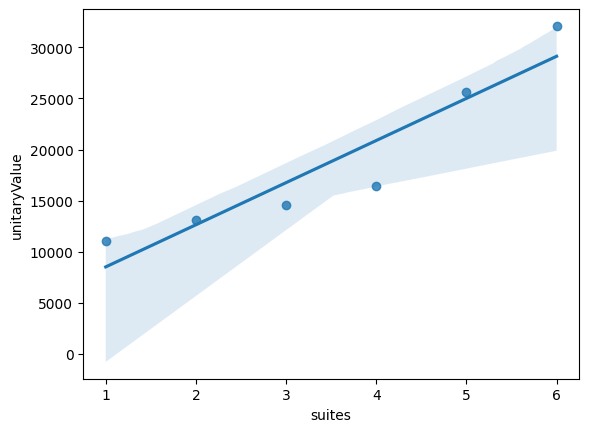

In [402]:
aux0 = df4[(df4['suites'] > 0) & (df4['unitaryValue'] < 60000)]

aux1 = aux0[['suites', 'unitaryValue']].groupby('suites').mean().reset_index()

sns.regplot(x='suites', y='unitaryValue', data=aux1);

#### Bathrooms: *true*

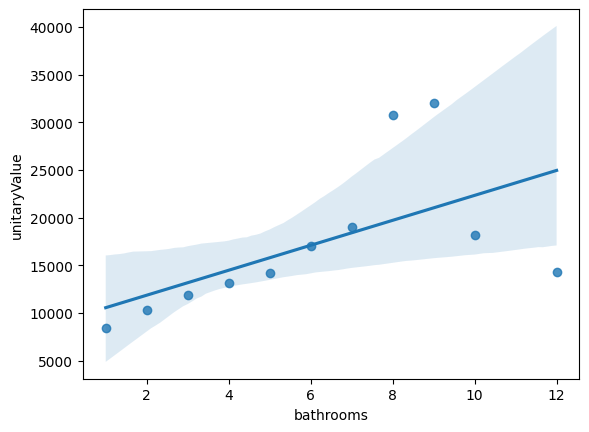

In [403]:
aux0 = df4[(df4['bathrooms'] > 0) & (df4['unitaryValue'] < 60000)]

aux1 = aux0[['bathrooms', 'unitaryValue']].groupby('bathrooms').mean().reset_index()

sns.regplot(x='bathrooms', y='unitaryValue', data=aux1);

#### Bedrooms: *false*

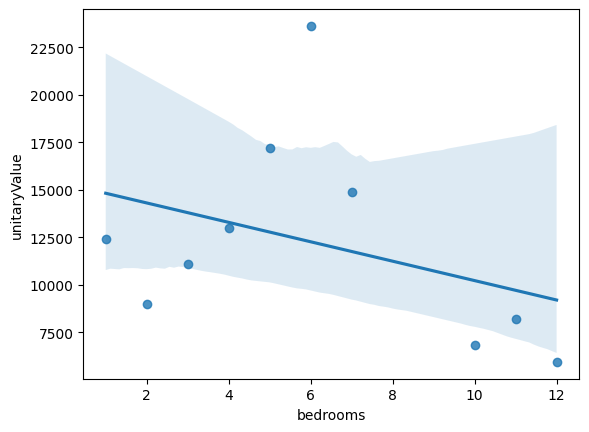

In [404]:
aux0 = df4[(df4['bedrooms'] > 0) & (df4['unitaryValue'] < 60000)]

aux1 = aux0[['bedrooms', 'unitaryValue']].groupby('bedrooms').mean().reset_index()

sns.regplot(x='bedrooms', y='unitaryValue', data=aux1);

#### Unit floor: *true*

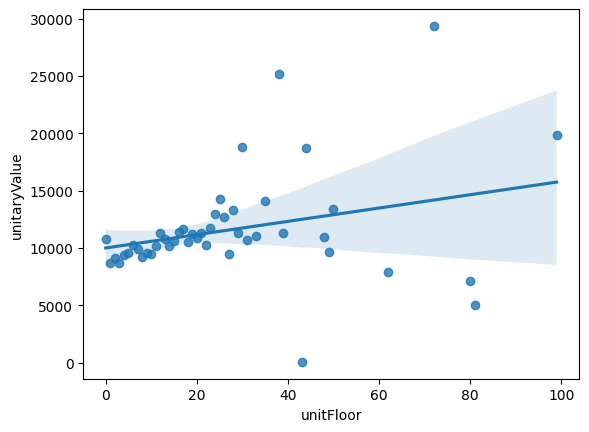

In [407]:
aux0 = df4[(df4['unitFloor'] < 100) & (df4['unitaryValue'] < 60000)]

aux1 = aux0[['unitFloor', 'unitaryValue']].groupby('unitFloor').mean().reset_index()

sns.regplot(x='unitFloor', y='unitaryValue', data=aux1);

#### Amenities: *inconclusive*

Inconclusive, filtering for less than 80 amenities show us a different trend for unitary value

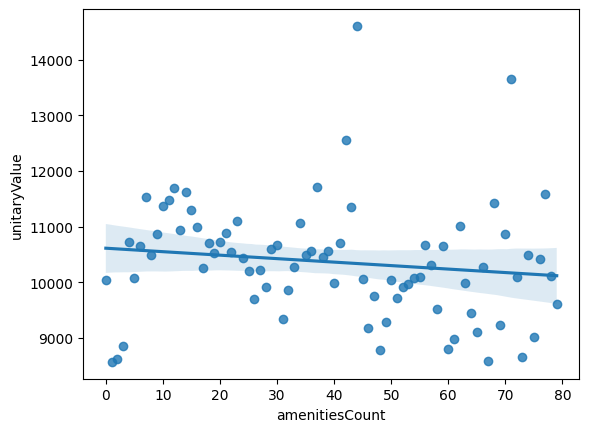

In [412]:
aux0 = df4[(df4['amenitiesCount'] < 80) & (df4['unitaryValue'] < 60000)]

aux1 = aux0[['amenitiesCount', 'unitaryValue']].groupby('amenitiesCount').mean().reset_index()

sns.regplot(x='amenitiesCount', y='unitaryValue', data=aux1);

#### Elevator, pool, gym and barbecue
    - true: Pool and gym
    - false: elevator and barbecue

In [426]:
aux0 = df4[(df4['unitaryValue'] < 60000)]

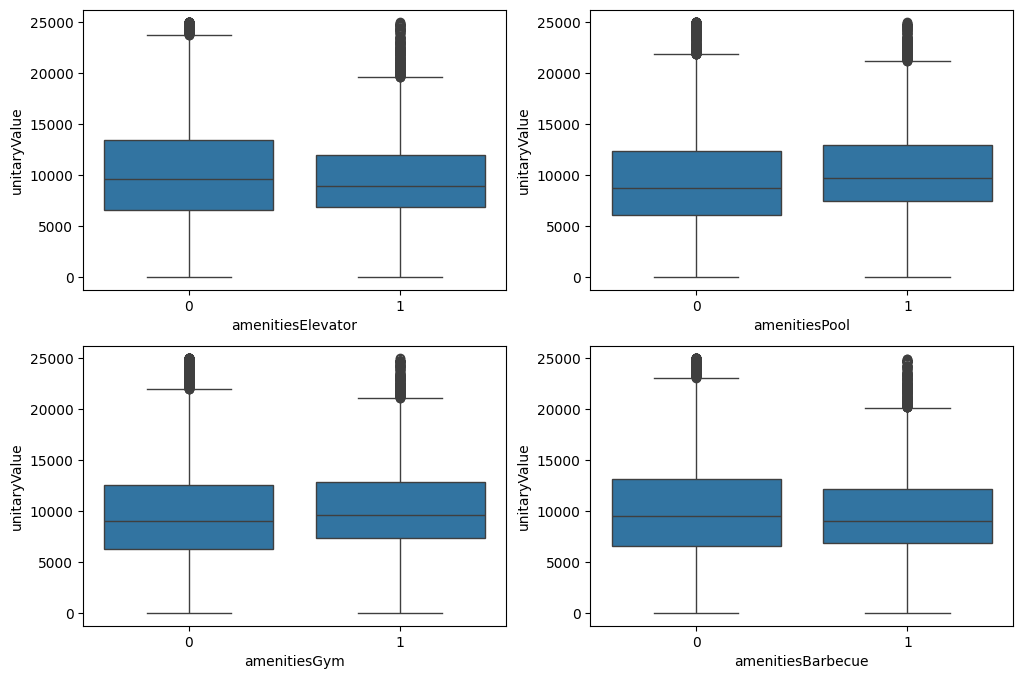

In [433]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.boxplot(x='amenitiesElevator', y='unitaryValue', data=aux0);

plt.subplot(2,2,2)
sns.boxplot(x='amenitiesPool', y='unitaryValue', data=aux0);

plt.subplot(2,2,3)
sns.boxplot(x='amenitiesGym', y='unitaryValue', data=aux0);

plt.subplot(2,2,4)
sns.boxplot(x='amenitiesBarbecue', y='unitaryValue', data=aux0);

### 4.3 Multivariate analysis

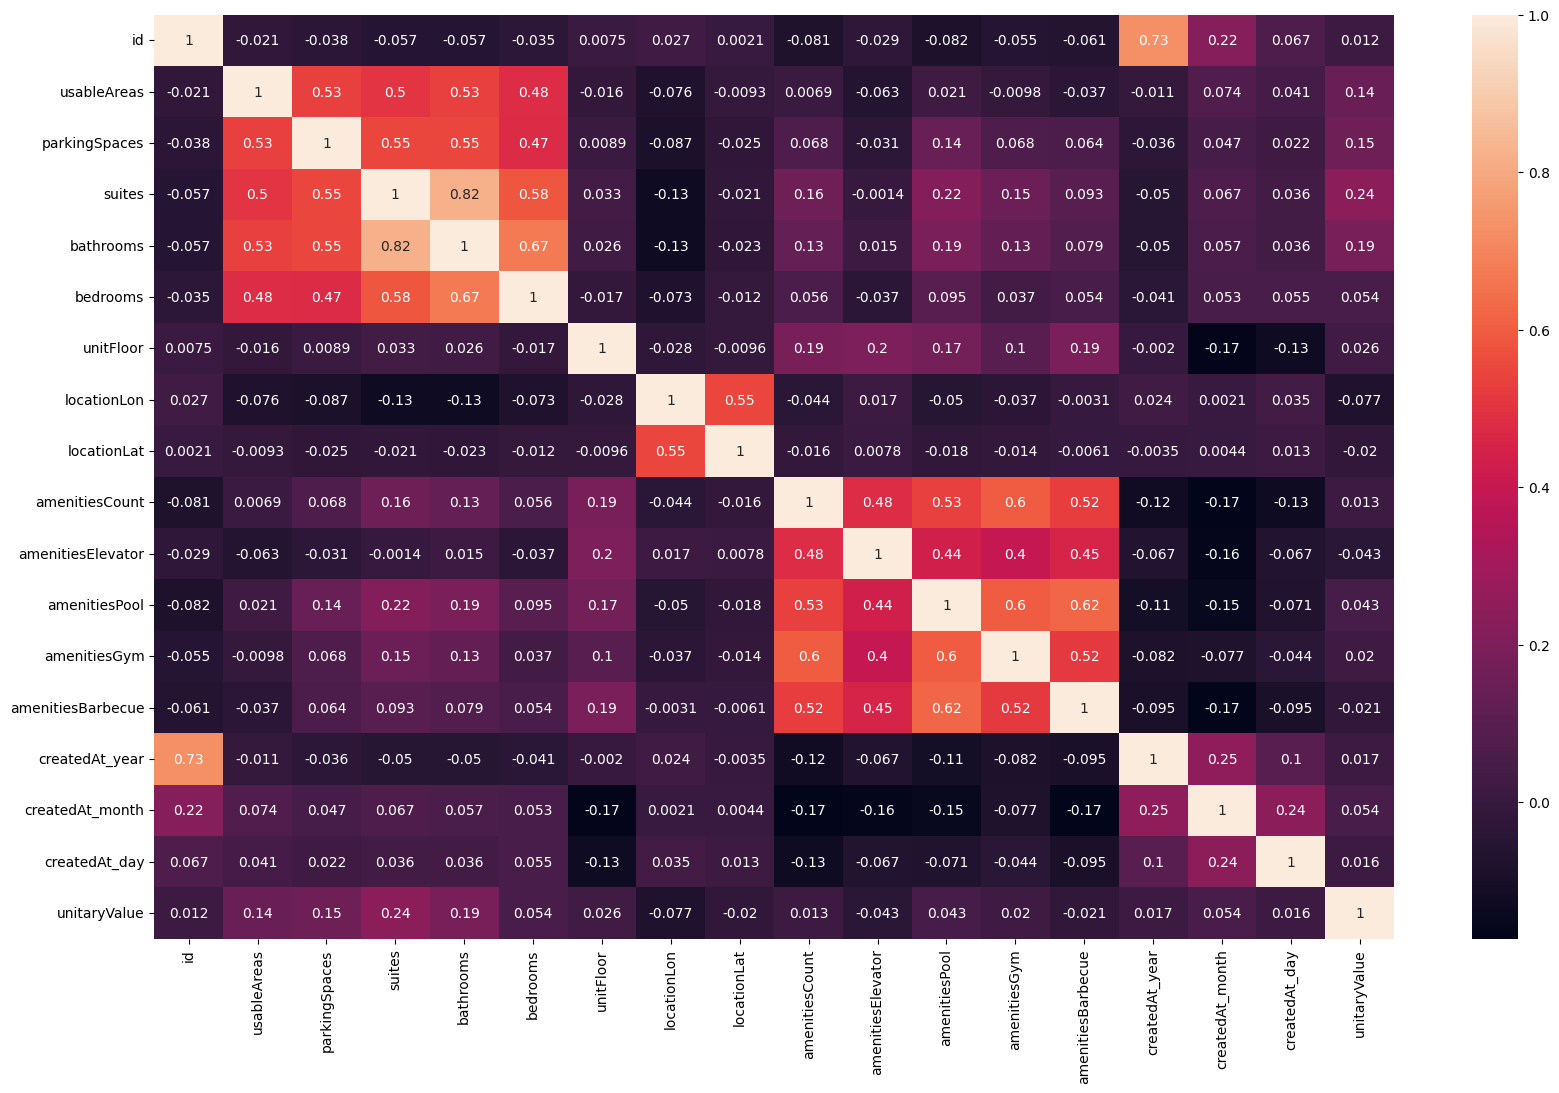

In [434]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20,12))
sns.heatmap(correlation, annot=True);

# 5.0 Data preparation

In [435]:
df5 = df4.copy()